# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision 
from PIL import Image
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import re
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random

# Dataset Paths

In [3]:
# Base path
BASE_PATH = Path(r"C:\Computer Vision Dataset\finalcsv")

# CSV folder inside base path
CSV_PATH = BASE_PATH / "clean"

# CSV file paths
TRAIN_CSV = CSV_PATH / "train_split_clean.csv"
VALID_CSV = CSV_PATH / "valid_split_clean.csv"
TEST_CSV = CSV_PATH / "test_split_clean.csv"

# Image folders
TRAIN_IMG_DIR = BASE_PATH / "Train"
VALID_IMG_DIR = BASE_PATH / "Valid"
TEST_IMG_DIR = BASE_PATH / "Test"

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

# Quick data check - are image IDs unique in each set?
print(f"Train IDs unique? {train_df['id'].is_unique}")
print(f"Validation IDs unique? {valid_df['id'].is_unique}")
print(f"Test IDs unique? {test_df['id'].is_unique}")

# Confirm image files exist for train set by appending .jpg to 'id'
missing_files = []
for img_id in tqdm(train_df['id'], desc="Checking train images"):
    img_file = TRAIN_IMG_DIR / f"{img_id}.jpg"  # Add .jpg extension here
    if not img_file.exists():
        missing_files.append(img_file.name)
print(f"Number of missing train images: {len(missing_files)}")

print("Step 1 complete: CSVs loaded and image files checked.")

Train samples: 47222
Validation samples: 5912
Test samples: 5896
Train IDs unique? True
Validation IDs unique? True
Test IDs unique? True


Checking train images:   0%|          | 0/47222 [00:00<?, ?it/s]

Number of missing train images: 0
Step 1 complete: CSVs loaded and image files checked.


# Label Definitions & Processing

In [13]:
LABELS = [
    "cardiomegaly", "edema", "consolidation", "atelectasis",
    "pleural_effusion", "pneumonia", "pneumothorax",
    "lung_opacity", "fracture", "support_devices"
]

In [15]:
def extract_labels(report):
    labels = {label: 0 for label in LABELS}
    report = report.lower()

    for label in labels:
        if re.search(label.replace("_", " "), report):
            labels[label] = 1
    return labels

In [17]:
def add_labels(df):
    label_data = df["text"].apply(extract_labels)
    label_df = pd.DataFrame(label_data.tolist())
    return pd.concat([df, label_df], axis=1)

train_df = add_labels(train_df)
valid_df = add_labels(valid_df)
test_df = add_labels(test_df)

# Data Loading and Preprocessing for Multimodal Input (Image + Report + Labels)

In [23]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, transform, is_train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.jpg")

        # Load and transform image
        image = self.transform(Image.open(img_path).convert("RGB"))

        # Tokenize report
        report = row["text"]
        encoded = self.tokenizer(
            report,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        )
        
        # Convert label columns to tensor
        label_tensor = torch.tensor([row[label] for label in LABELS], dtype=torch.float32)

        # IRM: 80% positive match, 20% random negative sample
        if self.is_train and torch.rand(1).item() > 0.8:
            # Random negative pair
            new_idx = (idx + 5) % len(self.df)
            neg_report = self.df.iloc[new_idx]["text"]
            encoded = self.tokenizer(neg_report, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
            match = 0
        else:
            match = 1

        return {
            "pixel_values": image,
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": label_tensor,
            "match": torch.tensor(match, dtype=torch.float32)
        }

In [25]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

In [27]:
ce_loss = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
bce_loss = BCEWithLogitsLoss()

In [ ]:
class ReportGenerator(nn.Module):
    def __init__(self, hidden_dim=768, num_labels=len(LABELS)):
        super().__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True)
        self.encoder.fc = nn.Identity()
        self.encoder_output = nn.Linear(2048, hidden_dim)

        self.decoder_config = BertConfig(is_decoder=True, add_cross_attention=True)
        self.decoder = BertModel(self.decoder_config)

        self.lm_head = nn.Linear(hidden_dim, tokenizer.vocab_size)
        self.irm_head = nn.Linear(hidden_dim, 1)
        self.label_head = nn.Linear(hidden_dim, num_labels)

    def forward(self, images, input_ids, attention_mask, match=None):
        img_feat = self.encoder(images)
        img_feat_embed = self.encoder_output(img_feat).unsqueeze(1)

        decoder_out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=img_feat_embed,
            encoder_attention_mask=torch.ones_like(img_feat_embed[:, :, 0])
        )
        lm_logits = self.lm_head(decoder_out.last_hidden_state)

        cls_feat = img_feat_embed.squeeze(1)
        irm_logit = self.irm_head(cls_feat).squeeze(1)  # IRM task
        label_preds = self.label_head(cls_feat)  # Disease label predictions

        return lm_logits, irm_logit, label_preds

In [ ]:
model = ReportGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [29]:
def generate_report(model, image_tensor, max_len=100, top_k=10):
    model.eval()
    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)

    with torch.no_grad():
        for _ in range(max_len):
            logits = model(image_tensor, input_ids, torch.ones_like(input_ids))[0]
            next_token_logits = logits[:, -1, :]

            # Top-k sampling
            topk_logits, topk_indices = torch.topk(next_token_logits, top_k)
            probs = F.softmax(topk_logits, dim=-1)
            next_token = topk_indices[0, torch.multinomial(probs[0], 1).item()].unsqueeze(0)

            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=-1)
            if next_token.item() == tokenizer.sep_token_id:
                break

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)


# Training

In [37]:
print("CUDA Available:", torch.cuda.is_available())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(0))


CUDA Available: True
Current Device: 0
Device Name: NVIDIA GeForce RTX 2080


In [49]:
print("Model on device:", next(model.parameters()).device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Model on device: cuda:0


In [43]:
train_dataset = ChestXrayDataset(train_df, TRAIN_IMG_DIR, tokenizer, image_transform, is_train=True)
val_dataset = ChestXrayDataset(valid_df, VALID_IMG_DIR, tokenizer, image_transform, is_train=False)

In [53]:
def full_training_loop(model, optimizer, tokenizer, device, 
                       train_dataset, val_dataset,
                       batch_size=4, epochs=20,
                       save_path="best_model.pt"):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    ce_loss = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    bce_loss = torch.nn.BCEWithLogitsLoss()

    best_f1 = 0.0
    best_epoch = 0
    train_losses = []
    val_losses = []
    f1_scores = []

    for epoch in range(epochs):
        print(f"\n===== Epoch {epoch + 1} =====")

        # Train
        model.train()
        total_train_loss = 0
        total_mlm = 0
        total_irm = 0
        total_label = 0

        for step, batch in enumerate(train_loader):
            if step % 100 == 0:
                print(f"🔄 Batch {step}/{len(train_loader)}")

            images = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            match_labels = batch["match"].to(device)
            disease_labels = batch["labels"].to(device)

            decoder_input_ids = input_ids[:, :-1]
            decoder_labels = input_ids[:, 1:]

            lm_logits, irm_logits, label_preds = model(images, decoder_input_ids, attention_mask[:, :-1])

            loss_mlm = ce_loss(lm_logits.reshape(-1, lm_logits.size(-1)), decoder_labels.reshape(-1))
            loss_irm = bce_loss(irm_logits, match_labels)
            loss_labels = bce_loss(label_preds, disease_labels)

            loss = loss_mlm + loss_irm + loss_labels

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()
            total_mlm += loss_mlm.item()
            total_irm += loss_irm.item()
            total_label += loss_labels.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_mlm = total_mlm / len(train_loader)
        avg_irm = total_irm / len(train_loader)
        avg_label = total_label / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        y_true_all = []
        y_pred_all = []
        with torch.no_grad():
            for batch in val_loader:
                images = batch["pixel_values"].to(device)
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                match_labels = batch["match"].to(device)
                disease_labels = batch["labels"].to(device)

                decoder_input_ids = input_ids[:, :-1]
                decoder_labels = input_ids[:, 1:]

                lm_logits, irm_logits, label_preds = model(images, decoder_input_ids, attention_mask[:, :-1])

                loss_mlm = ce_loss(lm_logits.reshape(-1, lm_logits.size(-1)), decoder_labels.reshape(-1))
                loss_irm = bce_loss(irm_logits, match_labels)
                loss_labels = bce_loss(label_preds, disease_labels)

                loss = loss_mlm + loss_irm + loss_labels
                val_loss += loss.item()

                y_true_all.append(disease_labels.cpu().numpy())
                y_pred_all.append(torch.sigmoid(label_preds).cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        y_true_all = np.concatenate(y_true_all, axis=0)
        y_pred_all = (np.concatenate(y_pred_all, axis=0) > 0.5).astype(int)
        f1 = f1_score(y_true_all, y_pred_all, average='micro')
        f1_scores.append(f1)

        print(f"🧠 Train Loss: {avg_train_loss:.4f} (MLM={avg_mlm:.4f}, IRM={avg_irm:.4f}, Labels={avg_label:.4f})")
        print(f"🧪 Val Loss: {avg_val_loss:.4f} | 🎯 F1 Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best model saved at epoch {epoch + 1} with F1 = {f1:.4f}")

    # Plot curves
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(f1_scores, label='F1 Score', color='green')
    plt.title("F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Training complete. Best F1 = {best_f1:.4f} at epoch {best_epoch + 1}")
    return train_losses, val_losses, f1_scores



===== Epoch 1 =====
🔄 Batch 0/11806
🔄 Batch 100/11806
🔄 Batch 200/11806
🔄 Batch 300/11806
🔄 Batch 400/11806
🔄 Batch 500/11806
🔄 Batch 600/11806
🔄 Batch 700/11806
🔄 Batch 800/11806
🔄 Batch 900/11806
🔄 Batch 1000/11806
🔄 Batch 1100/11806
🔄 Batch 1200/11806
🔄 Batch 1300/11806
🔄 Batch 1400/11806
🔄 Batch 1500/11806
🔄 Batch 1600/11806
🔄 Batch 1700/11806
🔄 Batch 1800/11806
🔄 Batch 1900/11806
🔄 Batch 2000/11806
🔄 Batch 2100/11806
🔄 Batch 2200/11806
🔄 Batch 2300/11806
🔄 Batch 2400/11806
🔄 Batch 2500/11806
🔄 Batch 2600/11806
🔄 Batch 2700/11806
🔄 Batch 2800/11806
🔄 Batch 2900/11806
🔄 Batch 3000/11806
🔄 Batch 3100/11806
🔄 Batch 3200/11806
🔄 Batch 3300/11806
🔄 Batch 3400/11806
🔄 Batch 3500/11806
🔄 Batch 3600/11806
🔄 Batch 3700/11806
🔄 Batch 3800/11806
🔄 Batch 3900/11806
🔄 Batch 4000/11806
🔄 Batch 4100/11806
🔄 Batch 4200/11806
🔄 Batch 4300/11806
🔄 Batch 4400/11806
🔄 Batch 4500/11806
🔄 Batch 4600/11806
🔄 Batch 4700/11806
🔄 Batch 4800/11806
🔄 Batch 4900/11806
🔄 Batch 5000/11806
🔄 Batch 5100/11806
🔄 B

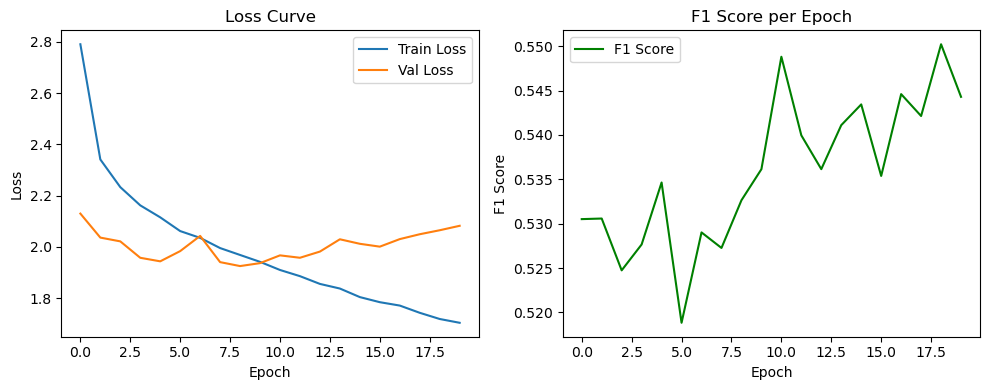


✅ Training complete. Best F1 = 0.5502 at epoch 19


In [55]:
train_losses, val_losses, f1_scores = full_training_loop(
    model=model,
    optimizer=optimizer,
    tokenizer=tokenizer,
    device=device,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=4,
    epochs=20,
    save_path="best_model_epoch.pt"
)

In [69]:
def evaluate_model(model, dataloader, tokenizer, device, label_names):
    model.eval()
    y_true_all = []
    y_probs_all = []

    ce_loss = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    bce_loss = torch.nn.BCEWithLogitsLoss()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            match_labels = batch["match"].to(device)
            disease_labels = batch["labels"].to(device)

            decoder_input_ids = input_ids[:, :-1]
            decoder_labels = input_ids[:, 1:]

            lm_logits, irm_logits, label_preds = model(
                images, decoder_input_ids, attention_mask[:, :-1]
            )

            loss_mlm = ce_loss(lm_logits.reshape(-1, lm_logits.size(-1)), decoder_labels.reshape(-1))
            loss_irm = bce_loss(irm_logits, match_labels)
            loss_labels = bce_loss(label_preds, disease_labels)

            loss = loss_mlm + loss_irm + loss_labels
            total_loss += loss.item()

            y_true_all.append(disease_labels.cpu().numpy())
            y_probs_all.append(torch.sigmoid(label_preds).cpu().numpy())

    # Convert to full arrays
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_probs_all = np.concatenate(y_probs_all, axis=0)
    y_pred_binary = (y_probs_all > 0.5).astype(int)

    # Classification report
    print("\n📊 Classification Report (per disease label):")
    print(classification_report(y_true_all, y_pred_binary, target_names=label_names, zero_division=0))

    avg_loss = total_loss / len(dataloader)
    print(f"\n🧪 Average Evaluation Loss: {avg_loss:.4f}")

    return y_true_all, y_probs_all


def plot_roc_auc(y_true, y_probs, label_names):
    plt.figure(figsize=(12, 8))

    for i, label in enumerate(label_names):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
        except ValueError:
            print(f"❌ Skipping '{label}' — only one class present in y_true.")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Label')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📊 Classification Report (per disease label):
                  precision    recall  f1-score   support

    cardiomegaly       0.48      0.03      0.05       909
           edema       0.57      0.07      0.13      1875
   consolidation       0.00      0.00      0.00      1311
     atelectasis       0.55      0.36      0.44      2178
pleural_effusion       0.60      0.94      0.73      3482
       pneumonia       0.00      0.00      0.00       880
    pneumothorax       0.61      0.92      0.73      3548
    lung_opacity       0.00      0.00      0.00        26
        fracture       0.00      0.00      0.00       260
 support_devices       0.25      0.00      0.01       210

       micro avg       0.60      0.51      0.55     14679
       macro avg       0.31      0.23      0.21     14679
    weighted avg       0.48      0.51      0.44     14679
     samples avg       0.59      0.49      0.50     14679


🧪 Average Evaluation Loss: 2.0652


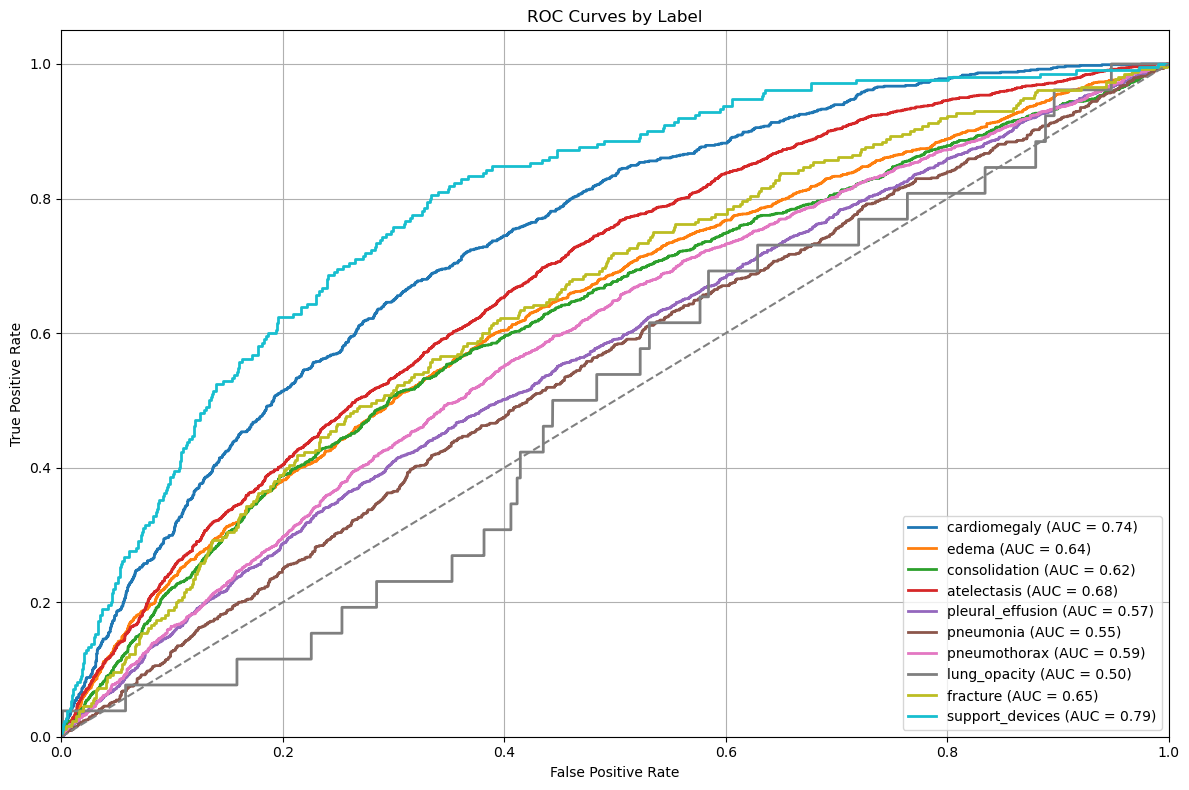

In [71]:
y_true, y_probs = evaluate_model(model, val_loader, tokenizer, device, LABELS)
plot_roc_auc(y_true, y_probs, LABELS)

In [81]:
# Load the best model
model.load_state_dict(torch.load("best_model_epoch.pt"))
model.to(device)

# Generate reports from validation dataset
show_generated_reports(model, val_dataset, tokenizer, device, num_samples=5)


📋 Generating 5 random reports from validation set...

📸 Image #4732
📄 Reference Report:
Moderate to severe pulmonary edema is unchanged. Large right and moderate left pleural effusions are stable associated adjacent atelectasis. Cardiomediastinal silhouette is unchanged. Lines and tubes are in unchanged standard position.
🧠 Generated Report:
the tip of the endotracheal tube projects 5 cm above the carina. the patient also has a nasogastric tube, the tube could be slightly advanced, given that it is well positioned in the stomach. the tip of the tube is not included on the image. the lung volumes are low. moderate cardiomegaly. mild right pleural effusion with subsequent atelectasis. no pulmonary edema. no pneumonia.
----------------------------------------------------------------------------------------------------
📸 Image #1486
📄 Reference Report:
Low bilateral lung volumes with bibasilar atelectasis. No focal consolidation, or pneumothorax identified. A trace right pleural effusion 

# Testing

In [83]:
model.load_state_dict(torch.load("best_model_epoch.pt"))
model.to(device)
model.eval()

ReportGenerator(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [85]:
test_dataset = ChestXrayDataset(test_df, TEST_IMG_DIR, tokenizer, image_transform, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [89]:
y_true_test, y_probs_test = evaluate_model(model, test_loader, tokenizer, device, LABELS)


📊 Classification Report (Test Set):
                  precision    recall  f1-score   support

    cardiomegaly       0.59      0.03      0.05       894
           edema       0.65      0.10      0.17      1830
   consolidation       0.00      0.00      0.00      1333
     atelectasis       0.55      0.37      0.45      2149
pleural_effusion       0.60      0.94      0.73      3488
       pneumonia       0.00      0.00      0.00       894
    pneumothorax       0.61      0.91      0.73      3506
    lung_opacity       0.00      0.00      0.00        31
        fracture       0.00      0.00      0.00       280
 support_devices       0.00      0.00      0.00       199

       micro avg       0.60      0.51      0.55     14604
       macro avg       0.30      0.24      0.21     14604
    weighted avg       0.49      0.51      0.44     14604
     samples avg       0.59      0.49      0.50     14604


🧪 Test Loss: 2.0713


In [91]:
def plot_roc_auc(y_true, y_probs, label_names):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(label_names):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
        except ValueError:
            print(f"❌ Skipping '{label}' — only one class present in y_true.")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves on Test Set')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

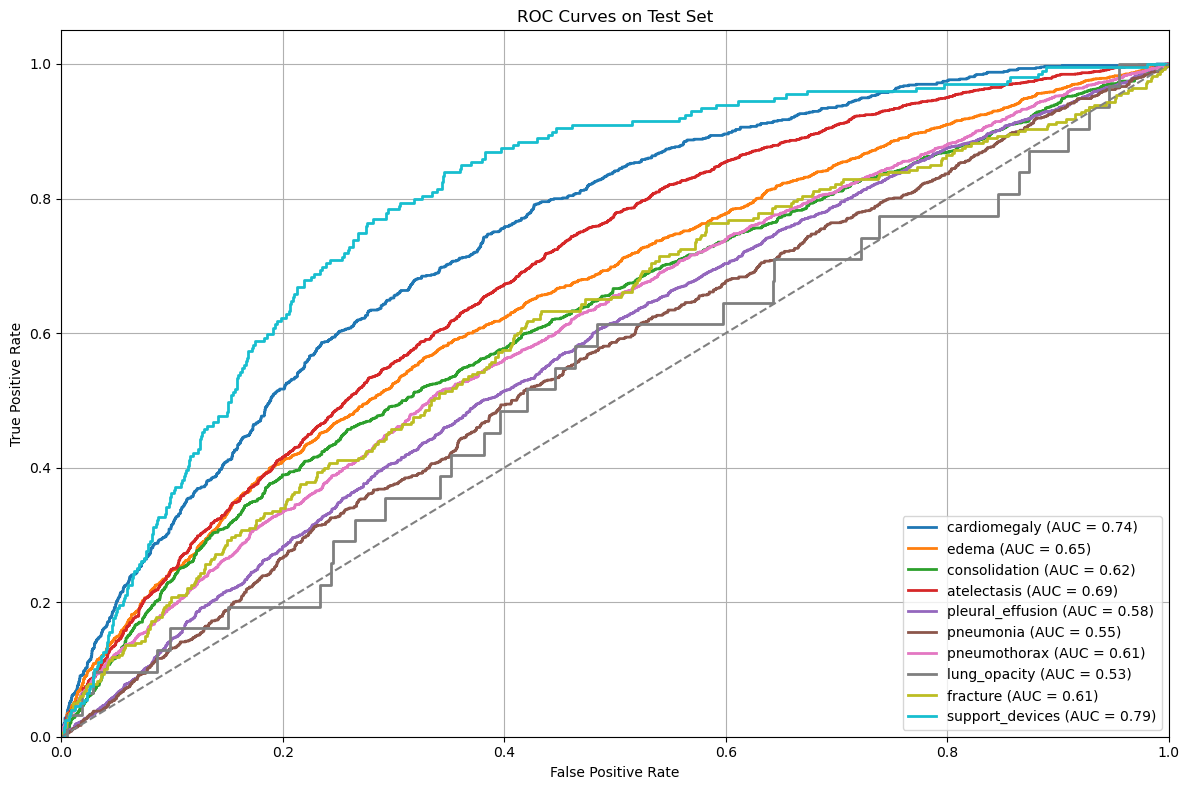

In [93]:
plot_roc_auc(y_true_test, y_probs_test, LABELS)

In [148]:
def show_generated_reports(model, dataset, tokenizer, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for i in indices:
        sample = dataset[i]
        image_tensor = sample["pixel_values"].unsqueeze(0).to(device)
        reference = dataset.df.iloc[i]["text"]
        generated = generate_report(model, image_tensor, max_len=100)

        print(f"📸 Image #{dataset.df.iloc[i]['id']}")
        print("📄 Reference Report:\n", reference)
        print("🧠 Generated Report:\n", generated)
        print("-" * 100)

show_generated_reports(model, test_dataset, tokenizer, device, num_samples=100)

📸 Image #s55176938
📄 Reference Report:
 Portable semi-upright radiograph of the chest demonstrates massive diffuse asymmetric pulmonary edema, right worse than left. Moderately severe cardiomegaly is unchanged. There is a small left-sided pleural effusion with adjacent atelectasis, and some right basilar atelectasis as well. There is no pneumothorax.
🧠 Generated Report:
 the right - sided picc has been removed. there is no pneumothorax. no focal consolidation. mild interstitial pulmonary edema has improved. mild cardiomegaly is unchanged. right - sided port terminates in the distal right atrium.
----------------------------------------------------------------------------------------------------
📸 Image #s56018571
📄 Reference Report:
 The cardiomediastinal and hilar contours are unchanged. Enteric tube ends in the stomach. Right PICC ends in the mid SVC. Right mid and lower lung consolidations are unchanged. Increasing left lung opacities may represent new developing areas of pneumonia.

In [102]:
# Step 1: Binarize predictions
y_pred_bin = (y_probs_test > 0.5).astype(int)

# Step 2: Limit to first 1000 samples
y_true_1k = y_true_test[:1000]
y_pred_1k = y_pred_bin[:1000]

# Step 3: Boolean masks
false_positives = (y_pred_1k == 1) & (y_true_1k == 0)
true_positives  = (y_pred_1k == 1) & (y_true_1k == 1)

# Step 4: Count per label
fp_count_per_class = false_positives.sum(axis=0)
tp_count_per_class = true_positives.sum(axis=0)
total_fp = false_positives.sum()
total_tp = true_positives.sum()

# Step 5: Print results
print(f"\n🚨 False Positives in First 1000 Samples: {total_fp}")
print(f"✅ True Positives in First 1000 Samples: {total_tp}")
for i, label in enumerate(LABELS):
    print(f"   - {label:17}: FP = {fp_count_per_class[i]} | TP = {tp_count_per_class[i]}")



🚨 False Positives in First 1000 Samples: 846
✅ True Positives in First 1000 Samples: 1278
   - cardiomegaly     : FP = 8 | TP = 2
   - edema            : FP = 22 | TP = 32
   - consolidation    : FP = 0 | TP = 0
   - atelectasis      : FP = 117 | TP = 134
   - pleural_effusion : FP = 368 | TP = 556
   - pneumonia        : FP = 0 | TP = 0
   - pneumothorax     : FP = 329 | TP = 554
   - lung_opacity     : FP = 0 | TP = 0
   - fracture         : FP = 0 | TP = 0
   - support_devices  : FP = 2 | TP = 0


In [124]:
def collect_all_test_reports(model, dataset, tokenizer, device):
    model.eval()
    references = []
    generated_reports = []

    for i in tqdm(range(len(dataset)), desc="Generating test reports"):
        sample = dataset[i]
        image_tensor = sample["pixel_values"].unsqueeze(0).to(device)
        reference = dataset.df.iloc[i]["text"]
        generated = generate_report(model, image_tensor, max_len=100)

        references.append(reference)
        generated_reports.append(generated)

    return references, generated_reports

# Run this to get all generated + reference reports on test set
references, generated_reports = collect_all_test_reports(model, test_dataset, tokenizer, device)

Generating test reports: 100%|██████████| 5896/5896 [2:20:05<00:00,  1.43s/it]  


In [144]:
!pip install -q bert_score

In [146]:
from bert_score import score

# Use the SciBERT model (suitable for biomedical domain)
P, R, F1 = score(
    cands=generated_reports,  # generated predictions
    refs=references,          # ground-truth references
    lang="en",
    model_type="allenai/scibert_scivocab_uncased",  # biomedical domain
    verbose=True
)

# 3️⃣ Print the average BERTScore
print(f"\n🔬 BERTScore (using SciBERT)")
print(f"  ➤ Precision: {P.mean().item():.4f}")
print(f"  ➤ Recall:    {R.mean().item():.4f}")
print(f"  ➤ F1 Score:  {F1.mean().item():.4f}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

C:\Users\kamal\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kamal\.cache\huggingface\hub\models--allenai--scibert_scivocab_uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/183 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

computing greedy matching.


  0%|          | 0/93 [00:00<?, ?it/s]

done in 32.04 seconds, 184.02 sentences/sec

🔬 BERTScore (using SciBERT)
  ➤ Precision: 0.6380
  ➤ Recall:    0.6238
  ➤ F1 Score:  0.6292
